<img src="https://drive.google.com/uc?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff" width="500"/>

---


# **Deep learning concepts**


#### **Morning contents/agenda**

1. Supervised VS unsupervised learning

2. Parameters and hyperparameters of a network

  &ensp;&ensp;&ensp;&ensp;2.1 Activation functions

  &ensp;&ensp;&ensp;&ensp;2.2 Losses

3. **Training is an optimisation problem**: gradient descent and backpropagation

4. Batch, mini-batch, and stochastic gradient descent

5. Bias and variance, and regularisers

#### **Learning outcomes**

1. Understand the difference between parameters and hyperparameters of a network

2. Understand how networks are trained using gradient descent and backpropagation

3. Understand how batch size works and the effect of regularisers in the training process


<br>

#### **Afternoon contents/agenda**

*Afternoon exercises are provided as additional content and will not be taught. We will instead focus on learning about PyTorch.*

1. Half-moon classifier

2. L2 regularisation on MNIST

#### **Learning outcomes**

1. Be able to build a simple classifier for simple datasets

2. Understand the effect of explicit regularisation during training

<br/>

---

<br/>

In [ ]:
!pip install pycm livelossplot
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 13.1 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


Today we will recap some of the concepts you have already seen in the ML module and introduce the basic building blocks of Deep Learning.

## 1. Supervised VS unsupervised learning

<img src="https://drive.google.com/uc?id=1o7x0OQhC48OYcBNamCXNLSPiR3Rf_MQZ" width="1000"/>

Definitions from the book Deep Learning (Goodfellow et al, 2016):

<img src="https://drive.google.com/uc?id=12hi4WwA3mVkVBS_blh3cUM11XUtBqkfn" width="1000"/>

There are other types of learning (reinforced, self-supervised, and semi-supervised).









<br/>

---

<br/>

## 2. Parameters and hyperparameters of a network

We use deep learning to perform tasks that usually rely on large amounts of data. Such tasks, or problems, are then formulated as optimisation problems involving neural networks.

Let's say that we have some data and a task that needs to be solved. We want to use a solution based on training a network, but a few questions arise:

1. What does training a network mean and how do we do it?
2. What is the network 'design'?
3. How do we choose the best 'design' for our problem?  

Let's look at each of those one by one:

<br>

### **What does training a network mean and how do we do it?**

Training a network means to find the optimal parameters of the network according to some measure that we define, usually using a **loss** function. The network parameters are the $\theta$ parameters we saw on the first day:

<img src="https://drive.google.com/uc?id=1rAh2U6ejO54rptSXbHTYqiTYg78mvOTe" width="800"/>

Network parameters are also referred to as weights and biases ($w$ and $b$ respectively), where the **weights** are the parameters that operate on the data inputs (our outputs of the previous layer), and the **biases** are an extra parameter we add to provide the network with extra flexibility:

<br>

<center><img src="https://drive.google.com/uc?id=1AtQhgLLuGKiLi8neVLNo1xQ91rfW7XLj" width="800"/></center>

<br>

To train a network is to find the parameters, which are (unsurprisingly) called **trainable parameters**, that better accomplish the task at hand. We will discuss the mechanism to measure this 'accomplishment' when we talk about loss functions further down.

<br>


### **What is the network 'design'?**

The design/shape/form of a network is known as its architecture. The architecture of the network is mostly controled by the network **hyperparameters**.

'Definition' from the book [Deep Learning](https://www.deeplearningbook.org/):

>*Most machine learning algorithms have hyperparameters, settings that we can use to control the algorithm’s behavior. The values of hyperparameters are not adapted by the learning algorithm itself (though we can design a nested learning procedure in which one learning algorithm learns the best hyperparameters for another learning algorithm).*

Examples of hyperparameters are:

- learning rate
- batch size
- loss type
- number of layers
- types of layers
- and a very long etc.

In essence, ***network settings that are not trainable***.

<br>

### **How do we choose the best *hyperparameters* for our problem?**

If they are not trainable, how do we find their optimal values then?

There are several methods to search for the best model hyperparameters. They all rely on exploring the effect these hyperparameters have on the training performance. The two most common strategies are grid and random search ([image source](https://medium.com/@cjl2fv/an-intro-to-hyper-parameter-optimization-using-grid-search-and-random-search-d73b9834ca0a)):

<br>

<p align = "center"><img src="https://miro.medium.com/max/1400/0*yDmmJmvRowl0cSN8.webp" width="400"/></p><p align = "center">

<br>

A good video by Andrew Ng on the topic [here](https://www.youtube.com/watch?v=AXDByU3D1hA)

<br>

In fact, this need to optimise hyperparameters is the reason why we split our data in three sets: training, validation, and testing. The table below summarises how each of these three datasets are used during a basic deep learning workflow:

<br>

| Dataset      | Used for training?| Used to find hyperparameters? | Good to assess Generalisation* |
| -----------    | :---: | :----: | :---: |
| Training set   | Yes      |  Partly | No  |
| Validation set | No       |  Yes | Partly  |
| Testing set    | No       |  No  | Yes |

<br>

\*Generalisation error (from Goodfellow et al, 2017):

>*The trained model must perform well on new, previously unseen data, not just those on which the model was trained. The ability to perform well on previously unseen data – or Test Data - is called Generalisation.*

<br>

### **Putting it all together**

Finally, a somewhat simplified workflow to design, train, and test a network would be something like this. For each set of hyperaparemeters we want to optimise:

1. Train each neural network (corresponding to each hyperparameter combination) using the training set.
2. Test performance on the validation set.
3. Pick the hyperparameters that give the best performance on the validation set.
4. Possibly retrain the network with optimal hyperparameters but now using both training and validation sets.
5. Test the network using the test set.

***The Test Set is the final measure of performance but must never be used in the Training.***

<br>


In the next two sections we will cover two special types of '***hyperparameters***'.

<br/>


## 2.1 Activation functions

Without activation functions, neural networks would just be a composition of linear operations. We introduce activation functions to introduce non-linearities:

<br>

<center><img src="https://drive.google.com/uc?id=1NFTxjal5zSaw8DC9ua6IDMdbwaT53sf4" width="800"/></center>

But why do we want to introduce non-linearities, and how do we do it?

This blog by Christopher Olah has a very nice visual explanation of it:

In [ ]:
%%html
<iframe src="https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/" width="1200" height="700"></iframe>

There are many different types of activation functions. Historically, the three most commonly used are:

- tanh
- sigmoid
- ReLU (Rectified Linear Unit)


<img src="https://miro.medium.com/max/1190/1*f9erByySVjTjohfFdNkJYQ.jpeg" width="210"/>

<img src="https://miro.medium.com/max/4800/1*XxxiA0jJvPrHEJHD4z893g.png" width="400"/>

But over time, many more have been developed:

<center><img src="https://drive.google.com/uc?id=1H6XZ-jCIbXZpff00CwqL0TcXbW57nlGb" width="800"/></center>

A special case of activation functions are those involving outputs from several neurons in each layer:

<center><img src="https://drive.google.com/uc?id=1xjF1HkWG3pQhZ0OFCmiHCPUDMSrwaji3" width="400"/></center>

[Link to wikipedia entry](https://en.wikipedia.org/wiki/Activation_function) about activation functions.


Fun version of the activation functions ([link](https://sefiks.com/2020/02/02/dance-moves-of-deep-learning-activation-functions/)):

<center><img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2020/02/sample-activation-functions-square.png?ssl=1" width="400"/></center>

To reiterate, activation functions act as non-linear operators that provide models with additional flexibility.

Play with different activations provided by PyTorch given a random tensor to see the effect they have. You can find them in the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity):

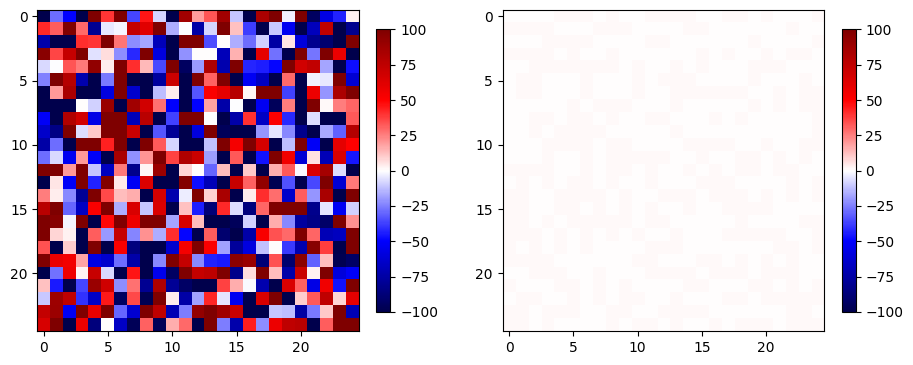

In [ ]:
# simple example of the effects of activation functions:
m = ##                      #### change this activation function to see what happens
input = torch.randn(25, 25)*100
output = m(input)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=5.0)
plt.rcParams["figure.figsize"] = (10,10)

im1 = ax1.imshow(input.detach().numpy(), cmap='seismic', vmin=-100, vmax=100)  # play with the colorscales to highlight the
im2 = ax2.imshow(output.detach().numpy(), cmap='seismic', vmin=-100, vmax=100) # effects ofthe different activations
plt.colorbar(im1, ax=ax1, fraction=0.04)
plt.colorbar(im2, ax=ax2, fraction=0.04)



## 2.2 Loss functions

Training a network is an optimisation procedure, and therefore it relies on being able to quantify somehow the performance of models (networks in DL). To do so, we define a quantity that distills the performance of the model to a single number, called the objective function. In deep learning, we often use a measure of 'error' for this, and we try to minimise it, hence the name loss function. This quantity has other names, most of them summarised in the following definition from the Deep Learning book (Goodfellow et al, 2016):

>*The function we want to minimize or maximize is called the objective function or criterion. When we are minimizing it, we may also call it the cost function, loss function, or error function.*

<br>

The two most common loss functions are:

- Mean squared error (MSE):  

$$ L_{MSE} = \frac{1}{N} \sum_i^N ( y_i - h_i(x) )^2$$

where $h_i(x)$ is an element of the output of the network, $y_i$ and element of what we define as the target, and $N$ is the total number of elements for this data sample. For example, $h_i(x)$ and $y_i$ could be pixels in an image, and $N$ the total number of pixels in this image.

<br>

- Cross entropy(CE):

$$ L_{CE} = \sum_j^M y_j \log(h_j(x)) $$

where $h_j(x)$ is the probability (calculated using softmax) of the sample to belong to class $j$, $y_j$ is the real probability of the sample belonging to this class (either 1 or 0), and $M$ is the total number of classes we are using in the classification. For example, in the network we implemented on the first day, we had 10 classes (digits 0-9), and every time we ran a sample (image of a handwritten digit) through our network, we had an output vector with 10 values corresponding to the probability of the sample to belong to each class.

<br>

It is trivial to see that if we only have two classes, we can use the binary cross entropy, which only requires the true probability to belong to one of the classes:

$$L_{BCE} = -y \log(h(x)) - (1 - y)\log(1-h(x))$$

which looks like:

<center><img src="https://drive.google.com/uc?id=1hvjfP5zmRIu-0mAbANx-mR856BDtil1S" width="400"/></center>


<br>

The loss in binary classification tasks, then, has this form:

<center><img src="https://drive.google.com/uc?id=1C56ycxV56Sclu9Zpf6O7tjN2hje5W_Sj" width="400"/></center>



<br>

#### **Clarifications and links to activations for the cross-entropy loss:**

The last layer of a binary classifier that uses a BCE loss is equivalent to logistic regression:

<br>

<center><img src="https://drive.google.com/uc?id=1AtQhgLLuGKiLi8neVLNo1xQ91rfW7XLj" width="800"/></center>

<br>

where the activation of the last layer is a sigmoid function:

<br>

<center><img src="https://drive.google.com/uc?id=1J3lm-Gm7x1FCRlORtGeAFoBjLwl4zxNB" width="600"/></center>

<br>

which also defines the decision boundary:

<center><img src="https://drive.google.com/uc?id=1Tas4jQySJY0HRS7sxiCS2czOiOv4f95o" width="700"/></center>

<br>

Do you remember https://playground.tensorflow.org/? There we could see either the value of the output of the last layer discretised (ie, the decision boundary), or the values of the last layer of the classifier (which only had one neuron and used a BCE loss):





In [ ]:
%%html
<iframe src="https://playground.tensorflow.org/" width="1200" height="700"></iframe>

But for the case of multiple classes, we can't use sigmoid. **Why not?**

<br>

Because when we have only two classes, we can calculate the probability of the second class given the probability of the first, as they both have to add up to one. And if we use a sigmoid activation in the last layer, since its value is restricted between zero and one, we can interpret it as a probability.

But this is no longer true for more than 2 classes, as reflected in the expression of the cross-entropy loss we saw above (where $h_j(x)$ is now $p_j$):

$$ L_{CE} = \sum_j^M y_j \log(p_j) $$


<center><img src="https://drive.google.com/uc?id=1GfPsikCYQKGFeqVMA9ahweVL1ogm3q43" width="700"/></center>


And now we have an output that can represent the probability of belonging to one of many multiple classes.

**Why is it a probability now?** Think about what all the numbers add up to.

The Cross Entropy implementation in `PyTorch` ([`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) does a bit more than advertised, as it performs a `Softmax` operation for us. If we don't want `PyTorch` to do this, we can use the Negative-Log-Likelihood-Loss ([`NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss)), because as we will see in the probability lecture, the cross entropy is the *same* as the negative of the log-likelihood.

In addition, `PyTorch`'s `CrossEntropyLoss` does a `LogSoftmax`, not a Softmax, and the reason for doing this is that taking the log of the softmax values does not change the positions of the solution(s) of our problem (as log it is a monotonic function), but scales the values to improve numerical stability.

<br>

You can find a complete list of losses provided by PyTorch [here](https://pytorch.org/docs/stable/nn.html#loss-functions)

<br>




<br>

---

<br>


## 3. Training is an optimisation problem: gradient descent and backpropagation

### **Gradient descent**

When we train a network we are finding the values of the model parameters (weights and biases) that minimise the loss function. The loss function defines a hypersurface in a space that has as many dimensions as model parameters.

That means that each combination of parameters correspond to a unique value of the loss, and we want to make this value as small as possible.

For example, if we had a very simple network with only two parameters, the loss (or solution space, as it is also often called) could look something like this:

<center><img src="https://drive.google.com/uc?id=13x5C07gQ4C7iViCayh9EvPONEPl40uuN" width="400"/></center>

In [ ]:
%%html
<iframe src="https://losslandscape.com/explorer" width="1200" height="700"></iframe>

By looking at the plot above, one may imagine that a simple solution would be to densely sample sufficient combinations of parameters, and then pick the lowest value you find. While this, in theory, would work, such brute force approach is completely infeasible in even the smallest networks which have at least thousands of parameters because it would take too long to sample this solutions space properly.

Instead, we use a **local optimisation** technique called **gradient descent**.

<center><img src="https://drive.google.com/uc?id=1i6iwsIMsnBDrlsHXET9kydpKNF0WjbeN" width="800"/></center>

where, for simplicity, in this example we assume that the 'network' is a simple multiplication by the value $\theta$.

**NOTE**: it is also common to use $J$ for the **loss** (or **cost** function)

In essence, gradient descent is a method that provides us with the information of the local curvature of the loss, and then we just update our model by changing the parameters in the steepest descent direction provided by the gradient expression. As the loss has a complex shape, this process needs to be iterated, as illustrated in the interactive web shown above.


In the figure above, we only have one parameter $\theta$, but in practice, our networks have many more parameters than that. Additionally, they have dependencies betwen them.

<br>

### **Backpropagation**

<center><img src="https://developer-blogs.nvidia.com/wp-content/uploads/2022/02/DS-Guide-to-Gradient-Descent_Pic5.gif" width="400"/></center>


The question is then, how do we use gradient descent to train our networks?

The answer is **backpropagation**: a combination of gradient descent and the derivative chain rule.

Let's illustrate it with a very simple step-by-step example:

<br>

<center><p>Step 1</p><img src="https://drive.google.com/uc?id=1OO0M9ZBPHle0XwMsGiYMmspe17Lb2T-4" width="800"/></center>

<br>

Here it is worth noting that $a_4$ depends on all the model parameters $w_i,b_i$.

<br>

<center><p>Step 2</p><img src="https://drive.google.com/uc?id=1GdVX-e8Jn70is2m2j06SFdbz2EYR2CLa" width="800"/></center>

<br>

where here we add a $\frac{1}{2}$ in front of the loss to simplify calculations:

$$\require{cancel}$$
$$\frac{\partial C}{\partial a_4} = \frac{1}{\cancel{2}} \cancel{2} (a_4 - y)$$

and then we continue with the chain rule:

<br>

<center><p>Step 3</p><img src="https://drive.google.com/uc?id=13SS5XgL-BXsEy37gsbsP_PvxO_bD6mi7" width="800"/></center>

<br>

And the same principle can be applied in networks with more neurons per layer, of course:

<center><img src="https://drive.google.com/uc?id=11ElETEZ_f4Rt5HhbXtIJibyEfwBsx3hk" width="800"/></center>

[Here](https://drive.google.com/file/d/1OF9mdC1pUXScfFxdmjucU3IjBIbburTD/view?usp=share_link) you can find a video recorded by Oscar Bates. In the video, he calculates by hand all the steps necessary to calculate gradients for all parameters for a simple network using backprop.

<br>

---

<br>

## 4. Batch, mini-batch, and stochastic gradient descent

So far we have analysed what happens when we put a single sample through a network, and how to use the loss to measure how well a network performs a given task.

In reality, our datasets are composed of hundreds, thousands, or even millions of samples. And now we should ask ourselves the question: how do we use all the data we have to train a network?

There are three different strategies to combine the data we have. In each of those, one **iteration** (one update of the model) consists of:

- **Batch gradient descent**: we use all the data samples (**batch**) we have, and for each we calculate a gradient. Once we have calculated all the gradients corresponding to all the data values, we combine them (average, sum, etc), and we update the model parameters using a particular learning rate.

<center><img src="https://drive.google.com/uc?id=11csHHXkwpK6O4hHTLzORJItjXpik5ogw" width="500"/></center>

- **Stochastic gradient descent**: we use only one random sample of the data to calculate a gradient (hence the name **stochastic**), and with this gradient we update the model before moving on the the next data sample.

<center><img src="https://drive.google.com/uc?id=1c7cfP2xNScvtbOK9ykYvWOD5IfPI7wFF" width="600"/></center>

- **Mini-batch gradient descent**: we use subsets of the data (**mini-batches**) to compute the gradients corresponding to each sample in the subset, then combine them (again, average, sum, etc), and update the model parameters.

<center><img src="https://drive.google.com/uc?id=1ujVe2J7kRbyh3e7Sir241X3P56U7E2wS" width="600"/></center>

When we are training networks, we normally define how many **epochs** we want to train. Every time we pass all the samples available in our dataset through our network for training, we have performed an epoch.

Visually ([gif source](https://medium.com/analytics-vidhya/gradient-descent-optimization-techniques-4316419c5b74)):
<center><img src="https://miro.medium.com/max/1400/1*m4taSeNUZzTiEr-aSv1c3w.gif" width="600"/></center>


**NOTE**:
`PyTorch` calls its mini-batch optimiser SGC (for stochastic gradient descent), which can be confusing. It is a nomenclature convention they use which is different from the one used here.

<br>

PyTorch provides different optimisers we can use. Two of the most common optimisers are **SGD with momentum** and **Adam**, and during this module we will use them quite a lot, but it is a good exercise to experiment with other algorithms.

In [ ]:
 %%html
<iframe src="https://pytorch.org/docs/stable/optim.html" width="1200" height="700"></iframe>

<br>

even though, at the end of the day:

<br>

<center><img src="https://miro.medium.com/max/1000/1*kqPSj6ylpvMf26rAiX7m6g.webp" width="500"/></center>


<br>

---

<br>

### **Exercise**

We will now revisit the network we implemented on the first day, but we will add a few modifications:

1. Add one extra layer to the network.
2. Add biases.
3. Change the activation functions
4. Change the batch size (try from pure SGD to full batch)
5. Modify the learning rate and observe what happens to the loss and accuracy evolution curves
6. Change the random seed

Also, discuss and try to justify which modifications make sense in this context.

#### Code definition - Skip to Network training for now

In [ ]:
import torch

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


In [ ]:
!pip install pycm livelossplot
%pylab inline

# Let's start by importing some Python and `Pytorch` libraries and define a random seed to be able to replicate our results.
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. Useful when inputs do not change size -
    torch.backends.cudnn.enabled   = False

    return True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 632.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.3/606.3 kB 13.5 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


We create a class called `simpleFFN` and we test that it reads an input and gives us an output:

In [ ]:
class simpleFFN(nn.Module):
  def __init__(self, num_hidden=(200, 50), bias=False, activation=nn.Sigmoid):
    super(simpleFFN, self).__init__()

    hidden_input = 784
    self.len_hidden = len(num_hidden)
    for idx, n in enumerate(num_hidden):
        setattr(self, 'hidden_%d' % idx, nn.Linear(hidden_input, n, bias=bias))
        hidden_input = n
    self.output = nn.Linear(hidden_input, 10, bias=bias)

    self.activation = activation()

  def forward(self, x):
    for idx in range(self.len_hidden):
        hidden = getattr(self, 'hidden_%d' % idx)
        z = hidden(x)
        x = self.activation(z)
    z = self.output(x)
    o = self.activation(z)
    return o

x = torch.randn((1, 1, 784))
model_test = simpleFFN()
y = model_test(x)
print(y)
print(model_test)



tensor([[[0.4471, 0.4859, 0.5717, 0.5687, 0.4071, 0.4074, 0.6212, 0.5051,
          0.3992, 0.4338]]], grad_fn=<SigmoidBackward0>)
simpleFFN(
  (hidden_0): Linear(in_features=784, out_features=200, bias=False)
  (hidden_1): Linear(in_features=200, out_features=50, bias=False)
  (output): Linear(in_features=50, out_features=10, bias=False)
  (activation): Sigmoid()
)


We download the MNIST dataset:

In [ ]:
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34109485.88it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1600905.20it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3376075.86it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7804395.23it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



We split the data in training, validation, and test sets:

In [ ]:
# split the data
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.data, mnist_train.targets)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


We standardise the data.

\[***NOTE***:
*As we will see in the coming weeks, even though this step is not strictly necessary, it does result in better performance because we are assuming that our data has some underlying Gaussian distribution (the errors rather). In general, it is good practice to standardise our data as it improves convergence speed and results in better generalisation.*\]

In [ ]:
def apply_standardization(X): # define an standardisation function
  X /= 255.
  X -= 0.1307
  X /= 0.3081
  return X

# standardise the data
X_train, y_train = apply_standardization(mnist_train.data[indices[0]].float()), mnist_train.targets[indices[0]]
X_val, y_val = apply_standardization(mnist_train.data[indices[1]].float()), mnist_train.targets[indices[1]]
X_test, y_test =  apply_standardization(mnist_test.data.float()), mnist_test.targets

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


We create TensorDatasets (more on this on the next two days):

In [ ]:
# create the TensorDatasets containing mnist_train, mnist_validate, and mnist_test
mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

And we plot one of the elements of the training set (to check we loaded the data correctly)

tensor(0.0001) tensor(1.0003)


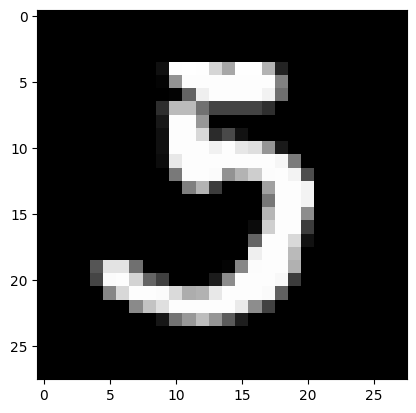

In [ ]:
plt.imshow(X_train[11], cmap = 'gray')
print(X_train.mean(), X_train.std())

Now we are going to define functions to train and validate our network:

In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()                         # the model is in the training mode so the parameters(weights)to be optimised will be updated
    train_loss, train_accuracy = 0, 0     # initialise loss and accuracy to 0 for training
    for X, y in data_loader:              # iterate over the mini-batches defined in the data loader
        X, y = X.to(device), y.to(device) # send data to the device (GPU in our case)
        optimizer.zero_grad()             # resetting optimiser info
        a2 = model(X.view(-1, 28*28))     # forward pass
        loss = criterion(a2, y)           # compute loss
        loss.backward()                   # backpropagation to calculate the gradients
        train_loss += loss*X.size(0)      # # add it up for different mini-batches and undo loss normalisation
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy
        optimizer.step()                  # perform a step of gradient descent

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset


def validate(model, criterion, data_loader):      # does not need optimiser
    model.eval()                                  # model is set to evaluation mode so no dropout or any other funny stuff here
    validation_loss, validation_accuracy = 0., 0. # initialise loss and accuracy to 0 for training
    for X, y in data_loader:                      # iterate over the mini-batches defined in the data loader
        with torch.no_grad():                     # deactivates autograd engine
            X, y = X.to(device), y.to(device)     # send data to the device (GPU in our case)
            a2 = model(X.view(-1, 28*28))         # forward pass
            loss = criterion(a2, y)               # evaluate loss
            validation_loss += loss*X.size(0)     # add it up for different mini-batches and undo loss normalisation
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # compute accuracy

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset

In order to figure out how good it is, we need to implement an evaluate function:

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device) # data and labels to device
            a2 = model(X.view(-1, 28*28))     # forward pass and reshape tensor and get it ready to the fully connected layer
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # calculate prediction
            ys.append(y.cpu().numpy())        # save predictions
            y_preds.append(y_pred.cpu().numpy()) # save predictions

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0) ## concatenate the labels of each batch into a single list

Let's also create a function to instantiate our model and send it to the device:

In [ ]:
def create_model(*args, **kwargs):
    model = simpleFFN(*args, **kwargs).to(device)                                              # instantiate model and send it to the GPU
    return model

And now we are ready to train our network:

In [ ]:
def train_loop(model, seed, lr, momentum, batch_size, test_batch_size, n_epochs):
    set_seed(seed)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)   # instantiate the optimizer
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 means that the main process will retrieve the data.
    validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

    liveloss = PlotLosses()    # plots evolution of loss and accuracy
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy

        liveloss.update(logs)
        liveloss.draw()
        print(validation_loss.item())

    return train_loader, validation_loader, test_loader

#### Network training

Select the hyperparameters of our training:

In [ ]:
seed = ## ## keep at that if you want to get almost the exact same results (down to numerical precision I guess)
lr = ##
momentum = ##
batch_size = ##
test_batch_size = ##
n_epochs = ##

Select the hyperparameters of our network:

In [ ]:
num_hidden = ##   # number of neurons in each hidden layer - in this case, we use 2 hidden layers: hidden_0 with 200 neurons and hidden_1 with 50 neurons
bias = ##         # no bias
activation = ##   # sigmoid activation function

Let's create our network model:

In [ ]:
model = ##
print(model)

And now we are ready to train our network and display the evolution in real time:

In [ ]:
train_loader, validation_loader, test_loader = train_loop(model, seed, lr, momentum, batch_size, test_batch_size, n_epochs)

In [ ]:
from torchsummary import summary
summary(model, (1,28*28))

<br>

---

<br>

## 5. Bias and variance, and regularisers:

### **Bias and variance**:

<center><img src="https://miro.medium.com/max/1400/1*LMExgwNg1emIEaN88TaU0g.png" width="600"/></center>

**Bias** (or underfitting) and **variance** (or overfitting) analogy in polynomial fitting:

<br>

<center><img src="https://drive.google.com/uc?id=1Y5QGrH4c0TQSW69j4YHuVtHHNK9g2FZ1" width="800"/></center>

<br>

The capacity of the model is closely related to the model complexity. Increasing the capacity of a model increases how expressive a model can be, or in other words, how much variation in the data it can accomodate. The capacity of the model has to be adapted to correctly capture the distribution of the data in the dataset.

<br>

<p align = "center"><img src="https://drive.google.com/uc?id=1m-DHiNaMyWtMQh_XO1qVdJr6tqEpMxfo" width="800"/></p><p align = "center">
<i>image from the book Deep learning (Goodfellow et. al 2016)</i>
</p>

<br>

We have already seen a case of bias (or underfitting) in the first training we did on Monday:

<p align = "center"><img src="https://drive.google.com/uc?id=1-ZGoWxDpIWGs7YcK3ZeljFHrbfTu-ho6" width="600"/></p><p align = "center">
<i>the model does not have enough capacity to predict the correct digits</i>
</p>

<br>

and from the exercise we did this morning, we can see a clear case of variance (overfitting):

<p align = "center"><img src="https://drive.google.com/uc?id=1pYHiHoOr-HDs6GLIQovkC4zvCAmkYvrS" width="600"/></p><p align = "center">
<i>the model does not have enough capacity to predict the correct digits</i>
</p>

<br>

The natural solution to avoid underfitting is to increase the capacity of our models, but to avoid overfitting is less straightforward. Sometimes we want to keep the expressivity of the model, but avoid overfitting to the training set.

A common strategy to solve this overfitting problem is to add **regularisation**, which aims at reducing variance (overfitting) without increasing bias (underfitting).

Regularisers can be:

- **explicit regularisers**: add terms to the loss definition

or

- **implicit regularisers**: adopt strategies that mitigate overfitting by any other means, for example dropout, or data augmentation.

<br>

### **Explicit regularisers**

There is a wide range of explicit regularisers we could use (some people even use networks as added terms to the loss). But the two most common ones are:

### $L_1$:

<p align = "center"><img src="https://drive.google.com/uc?id=12L-_zhhxvcUlcMkLoixaYWI9OAJPtaLM" width="400"/></p><p align = "center">
</p>

<br>

### $L_2$

<p align = "center"><img src="https://drive.google.com/uc?id=1kwAjka3DDw6-Gwa50LbNErtMI8-8pRYF" width="400"/></p><p align = "center">
</p>

Where in both cases the parameter $\lambda$ controls the strength of the regularisation. Is this a hyperparameter? And how do we choose the optimal one?


<p align = "center"><img src="https://drive.google.com/uc?id=1eQLceu0vWamhmPSBhm3KOVvT6R_dKZ_n" width="600"/></p><p align = "center">
</p>

We try different values of $\lambda$ and select the best one.

<br>

### **Implicit regularisers**

We will cover three examples of implicit regularisers in this section: dropout, data augmentation, and batch normalisation. We focus on these three because they are routinely used in deep learning, and they have proven to be robust solutions in a wide variety of problems.


### Dropout



<p align = "center"><img src="https://drive.google.com/uc?id=1kAyDhJyZZVRbkJwlr6R6R-MgJ2wHJdvc" width="800"/></p><p align = "center">
image from <i>Dropout: A Simple Way to Prevent Neural Networks from Overfitting (Srivastava, Hinton, et al 2014)</i>
</p>

<br>

<p><img src="https://drive.google.com/uc?id=1LeOaSWkhJngqOvx2Kqx2GuAGrvtwYoda" width="1000"/></p><p>
</p>

<br>

Dropout is implemented by defining a parameter $p$ that defines the probability of a neuron in a layer to be dropped, and it is only applied during training. During inference (when we are using a trained model), we don't apply dropout, but instead scale the outputs of the neurons by a factor $p$ to keep the magnitude of the data consistent as it goes through the network.

As part of the PyTorch lecture with Debbie, we will see the use of `model.train()` and `model.eval()`. Among other things, these activate or deactive the dropout in the `nn.Module` we define.

A video by Hinton explaining it in more detail [here](https://www.youtube.com/watch?v=kAwF--GJ-ek)

Finally, dropout can also be interpreted as a form of [ensemble learning](https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/).

<br>

### Data augmentation

Data augmentation is a strategy to increase our dataset by generating new samples based on the original dataset. These modifications should not change the ideal response of the network to them. Common strategies to augment image datasets are:
- rotate
- translate
- zoom
- crop
- add noise
- change brightness level

<br>

<p><img src="https://drive.google.com/uc?id=112km6vplABWQklLMZsteUO-0lBHhzndr" width="800"/></p><p>
</p>

<br>

### Batch normalisation



Batch normalisation is based on normalising the outputs of the neurons (normally applied after activations, but could be applied before too). We have already seen that it is desirable to standardise the inputs, and batch normalisation extends this concept to the layers of the model.

This normalisation is controled by parameters that are also updated during training.

There are different interpretations of what batch normalisation does. Some people interpret it as a means to reduce the internal covariate shift (see [original paper](https://arxiv.org/abs/1502.03167) for details), but more recent developments seem to point that it acts as a regulariser that smooths the objective function (and therefore make it better suited to gradient descent minimisation methods).

***internal covariate shift***: *changes in the distribution of data as it navigates through the layers of the networks.*

In summary, batch normalisation:

- Normalises (standardises) values at each layer of the network, instead of just on input layer.
- Accelerates training by stabilizing the layer changes through the iterations.
- Provides some regularization, like dropout, but not as strong (open topic of discussion).
- Batch normalisation should really be called batch standardization.
It reduces the probability that vanishing or exploding gradients occur.

[A good video by Andrew Ng](https://www.youtube.com/watch?v=tNIpEZLv_eg) on this topic

<br>

---

<br>

